In [1]:
# setting where do you put your jar file
import jnius_config
jnius_config.set_classpath('jquantum.1.0.jar')

# autoclass is wrapper for your java class
from jnius import autoclass
jInit = autoclass('jqc.Initialization')
jinit = jInit()

In [2]:
import numpy as np
import json
from scipy.special import factorial

ZAtoms = {"H":1,"He":2,"Li":3,"Be":4,"B":5,"C":6,"N":7,"O":8,"F":9,"Ne":10,
          "Na":11,"Mg":12,"Al":13,"Si":14,"P":15,"S":16,"Cl":17,"Ar":18,
          "K":19,"Ca":20,"Sc":21,"Ti":22,"V":23,"Cr":24,"Mn":25,"Fe":26,"Co":27,"Ni":28,"Cu":29,"Zn":30,"Ga":31,"Ge":32,"As":33,"Se":34,"Br":35,"Kr":36}
          #,Rb,Sr,Y,Zr,Nb,Mo,Tc,Ru,Rh,Pd,Ag,Cd,In,Sn,Sb,Te,I,Xe,Cs,Ba,La,Ce,Pr,Nd,Pm,Sm,Eu,Gd,Tb,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,W,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn,Fr,Ra,Ac,Th,Pa,U,Np,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr,Rf,Db,Sg,Bh,Hs,Mt,Ds,Rg,Cn,Nh,Fl,Mc,Lv,Ts,Og}

angularNumbers = {"s":[[0,0,0]], "p":[[1,0,0],[0,1,0],[0,0,1]], "d":[[2,0,0],[1,1,0],[1,0,1],[0,2,0],[0,1,1],[0,0,2]],
                  "f":[[3,0,0],[2,1,0],[2,0,1],[1,2,0],[1,1,1],[1,0,2],[0,3,0],[0,2,1],[0,1,2],[0,0,3]] }
bondLenght = 1.889725989

dataset = [] #all data in class data will be contained in this list

class data: 
  def __init__(self, atom, R, angular, lnum, prim, cont, ZAtom):
    self.atom = atom        #discribe number electron, atom's name, state
    self.R = R              #position atom
    self.angular = angular
    self.lnum = lnum        #quantum number Ylmn {spd....}
    self.prim = prim        #pangkat/alpha/exponent
    self.cont = cont[0]     #coefecient
    self.ZAtom = ZAtom      #number atom {Z}
    self.norm = normalized(self.prim,self.lnum) #additional calculation normalization each basis i for all quantum number

def setData(atoms,position,basis):
  dataset.clear()
  file = open('basis/'+basis+'.json',)
  datajs = json.load(file)
  position = np.array(position)*bondLenght
  for i,atom in zip(range(len(atoms)),atoms):
    for d in datajs[atom]: 
      for lnum in angularNumbers[d['angular']]:
        dataset.append(data(atom, position[i], d['angular'], lnum, d['prim'], d['cont'], ZAtoms[atom]))
  file.close() 

def normalized(prim,l):
  norm = np.zeros(len(prim))
  for i in range(len(prim)):
    norm[i] = np.sqrt(np.power(2, 2 *(l[0]+l[1]+l[2])+1.5) * np.power(prim[i],l[0]+l[1]+l[2]+1.5)/(factorial(factorial(2*l[0]-1)) * factorial(factorial(2 * l[1] - 1)) * factorial(factorial(2 * l[2] - 1)) * np.power(np.pi, 1.5)))
  return norm

def printDataset() : 
  for i in range(len(dataset)):
    print("atom: ",i+1, dataset[i].atom, dataset[i].angular)
    print("Position: ",dataset[i].R)
    print("Cont: ", dataset[i].cont)
    print("lnum: ", dataset[i].lnum)
    print("Prim: ", dataset[i].prim)
    print("ZAtom: ", dataset[i].ZAtom)
    print("normalized: ", dataset[i].norm)
    print("-------------------------")

In [3]:
def convertDataset_to_JavaDataset():
    jinit.resetData()
    for i in range(len(dataset)):
        jinit.setBasisData(i,dataset[i].atom, dataset[i].angular,
                  dataset[i].R.tolist(),
                  dataset[i].prim,
                  dataset[i].lnum,
                  dataset[i].cont,
                  dataset[i].ZAtom,
                  dataset[i].norm.tolist()
                  )

n    = len(dataset)
ints = np.zeros((n,n,n,n))
Ek   = np.zeros((n,n))
Ev   = np.zeros((n,n))
S    = np.zeros((n,n))

def kernel(atoms,position,spinUp,spinDn,excName,basis):
    setData(atoms,position,basis)
    #printDataset()
    convertDataset_to_JavaDataset()
    
    Z = []
    for i in range(len(atoms)):
        Z.append(ZAtoms[atoms[i]])
    jMole = autoclass('jqc.Mole')
    jmole = jMole(atoms,position,Z,spinUp,spinDn,excName)
    jinit.runInit(jmole)

    Ek = jinit.Ek
    Ev = jinit.Ev
    S = jinit.S
    ints = jinit.ints
    #print(len(Ek))
    #print(Ev)
    #print(S)
    #print(ints)
    
    jSCF = autoclass('jqc.SCF')
    jscf = jSCF(jmole, jinit.getBasisData())
    Emin = jscf.run(Ek,Ev,S,ints)
    return Emin

In [4]:
#Test running molecule Water H2O
molecule = 'H2O'
atoms = ['O','H','H']
position = [[0, 0, 0.1173],[0, 0.7572, -0.4692],[0, -0.7572, -0.4692]]
spinUp = 5
spinDn = 5
excName = "LDA"
basis = 'sto-3g'
Etot = kernel(atoms,position,spinUp,spinDn,excName,basis)
print(Etot)

-74.06515256747129


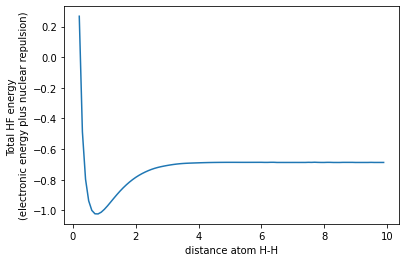

In [5]:
#Test Hydrogen molecule H2 Bonding with variation R
import matplotlib.pyplot as plt

molecule = "H2"
atoms = ['H','H']
spinUp = 1
spinDn = 1
excName = "LDA"
basis = 'sto-3g'
R = np.arange(0.2, 10, 0.1).tolist()
nr = len(R)
Etot = np.zeros(nr)
for i in range(nr):
    position = [[0,0,0],[0,0,R[i]]]
    Etot[i] = kernel(atoms,position,spinUp,spinDn,excName,basis)
    
plt.plot(R,Etot)
plt.ylabel('Total HF energy \n(electronic energy plus nuclear repulsion)')
plt.xlabel('distance atom H-H')
plt.show()

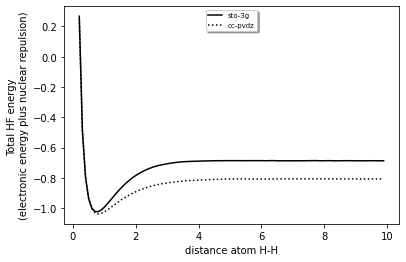

In [6]:
#Comparing H2 bonding with other basis
basis = 'cc-pvdz'
Etot2 = np.zeros(nr)
for i in range(nr):
    position = [[0,0,0],[0,0,R[i]]]
    Etot2[i] = kernel(atoms,position,spinUp,spinDn,excName,basis)

fig, ax = plt.subplots()
ax.plot(R, Etot, 'k-', label='sto-3g')
ax.plot(R, Etot2, 'k:', label='cc-pvdz')

plt.ylabel('Total HF energy \n(electronic energy plus nuclear repulsion)')
plt.xlabel('distance atom H-H')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-small')
plt.show()